In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import torch
from torch import nn, tensor
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import transforms, ToTensor
import torchvision.utils as vutils


MODEL_E_PATH = "anime-64x64-e.pth"
MODEL_G_PATH = "anime-64x64-g.pth"
EXPORT_PATH = "raw-weights-anime-64x64"


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [2]:
class AnimeFaceDataset(Dataset):

    def __init__(self, transform=None, target_transform=None):
        self.size = 64
        self.path = "../data/AnimeFace/64x64.raw"
        raw_bytes = np.fromfile(self.path, dtype=np.uint8)
        self.content = raw_bytes.reshape((60000, 3, 64, 64))
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        #return 10000
        return 60000

    def __getitem__(self, i):
        return self.content[i%1000].astype(np.float32) / 255.0


def load_data(dataset, plot=False):
    dataloader = DataLoader(
        dataset,
        batch_size=128,
        shuffle=True
    )
    for x in dataloader:
        print("Shape of x:", x.shape)
        break
    if plot:
        plt.figure(figsize=(8, 8))
        plt.axis("off")
        plt.title("Training Images")
        plt.imshow(np.transpose(vutils.make_grid(
            next(iter(dataloader)).to(device)[:64],
            padding=2, pad_value=0.5, normalize=True).cpu(), (1, 2, 0)),
                   interpolation='nearest')
        plt.show()
    return dataloader


In [3]:
LATENT = 64
DIMS_E = [32, 64, 64, 32]
DIMS_G = [64, 64, 64, 64, 64, 3, -1, -1]

# activation = nn.ReLU
activation = nn.SiLU

class Encoder(nn.Module):

    def __init__(self):
        super(Encoder, self).__init__()
        # Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0)
        dims = DIMS_E
        self.main = nn.Sequential(
            # 3 x 64x64
            nn.Conv2d(3, dims[0], 4, 2, 1, bias=False),
            nn.BatchNorm2d(dims[0]),
            activation(inplace=True),
            # dims[0] x 32x32
            nn.Conv2d(dims[0], dims[1], 4, 2, 1, bias=False),
            nn.BatchNorm2d(dims[1]),
            activation(inplace=True),
            # dims[1] x 16x16
            nn.Conv2d(dims[1], dims[2], 4, 2, 1, bias=False),
            nn.BatchNorm2d(dims[2]),
            activation(inplace=True),
            # dims[2] x 8x8
            nn.Conv2d(dims[2], dims[3], 4, 2, 1, bias=False),
            nn.BatchNorm2d(dims[3]),
            activation(inplace=True),
            # dims[3] x 4x4
            nn.Conv2d(dims[3], LATENT, 4, 1, 0, bias=False),
            nn.Flatten()
        )

    def forward(self, x):
        return self.main(x)


class Generator(nn.Module):

    def __init__(self):
        super(Generator, self).__init__()
        # ConvTranspose2d(in_channels, out_channels, kernel_size, stride=1, padding=0)
        # https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md
        dims = DIMS_G
        layers = [
            # LATENT
            nn.Linear(LATENT, dims[0]*4*4, bias=True),
            activation(inplace=True),
            nn.Unflatten(1, (dims[0], 4, 4)),
            nn.Conv2d(dims[0], dims[1], 3, 1, 1, bias=False),
            nn.BatchNorm2d(dims[1]),
            activation(inplace=True),
            # dims[1] x 4x4
            nn.ConvTranspose2d(dims[1], dims[2], 4, 2, 1, bias=False),
            nn.BatchNorm2d(dims[2]),
            activation(inplace=True),
            # dims[2] x 8x8
            nn.ConvTranspose2d(dims[2], dims[3], 4, 2, 1, bias=False),
            nn.BatchNorm2d(dims[3]),
            activation(inplace=True),
            # dims[3] x 16x16
            nn.ConvTranspose2d(dims[3], dims[4], 4, 2, 1, bias=False),
            nn.BatchNorm2d(dims[4]),
            activation(inplace=True),
            # dims[4] x 32x32
            nn.ConvTranspose2d(dims[4], dims[5], 4, 2, 1, bias=False),
            nn.BatchNorm2d(dims[5]),
            # nn.SiLU(inplace=True),
            # nn.Conv2d(dims[5], dims[6], 3, 1, 1, bias=False),
            # nn.SiLU(inplace=True),
            # nn.Conv2d(dims[6], 3, 3, 1, 1, bias=False),
            nn.Tanh()
            # 3 x 64x64
        ]
        layers = [layer for layer in layers if layer is not None]
        self.main = nn.Sequential(*layers)

    def forward(self, x):
        return self.main(x)


Shape of x: torch.Size([128, 3, 64, 64])
Encoder 165760
Encoder(
  (main): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): SiLU(inplace=True)
    (6): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): SiLU(inplace=True)
    (9): Conv2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): SiLU(inplace=True)
    (12): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (13): Flatten(start_

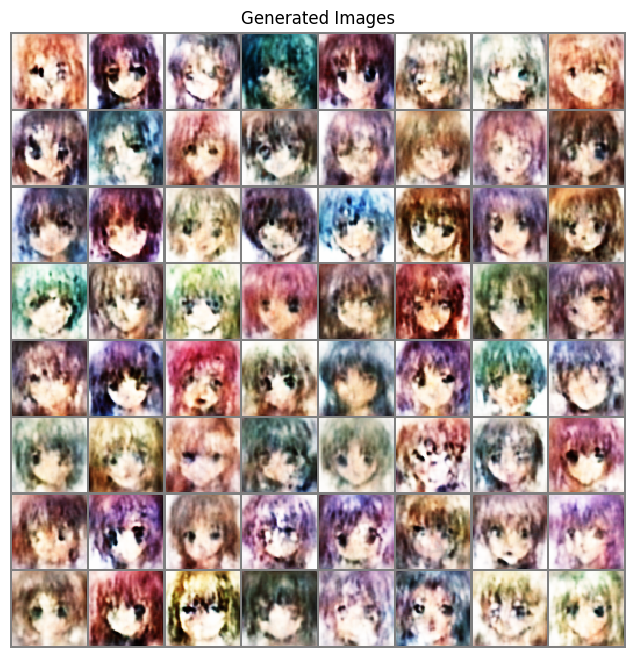

Epoch 2
[100/469]  loss: (l1=0.0587 ssim=0.2140 -> 0.2900) vae=0.1014 -> 0.3915
[200/469]  loss: (l1=0.0610 ssim=0.2116 -> 0.2975) vae=0.1011 -> 0.3986
[300/469]  loss: (l1=0.0576 ssim=0.1995 -> 0.2809) vae=0.0910 -> 0.3719
[400/469]  loss: (l1=0.0597 ssim=0.2107 -> 0.2925) vae=0.0993 -> 0.3917
Epoch 3
[100/469]  loss: (l1=0.0578 ssim=0.1962 -> 0.3297) vae=0.0979 -> 0.4276
[200/469]  loss: (l1=0.0572 ssim=0.1823 -> 0.3177) vae=0.0926 -> 0.4102
[300/469]  loss: (l1=0.0563 ssim=0.1832 -> 0.3154) vae=0.1048 -> 0.4201
[400/469]  loss: (l1=0.0562 ssim=0.1735 -> 0.3081) vae=0.1197 -> 0.4278
Epoch 4
[100/469]  loss: (l1=0.0582 ssim=0.1812 -> 0.3639) vae=0.1155 -> 0.4794
[200/469]  loss: (l1=0.0549 ssim=0.1665 -> 0.3386) vae=0.1076 -> 0.4462
[300/469]  loss: (l1=0.0573 ssim=0.1650 -> 0.3440) vae=0.1269 -> 0.4708
[400/469]  loss: (l1=0.0536 ssim=0.1545 -> 0.3220) vae=0.1046 -> 0.4266


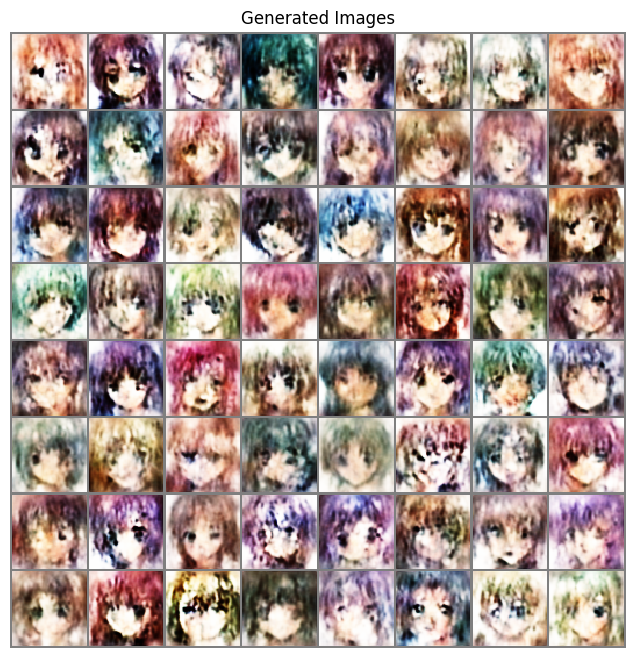

Epoch 5
[100/469]  loss: (l1=0.0534 ssim=0.1507 -> 0.3520) vae=0.1022 -> 0.4542
[200/469]  loss: (l1=0.0548 ssim=0.1539 -> 0.3601) vae=0.1076 -> 0.4677
[300/469]  loss: (l1=0.0537 ssim=0.1453 -> 0.3450) vae=0.1186 -> 0.4636
[400/469]  loss: (l1=0.0525 ssim=0.1408 -> 0.3354) vae=0.1073 -> 0.4427
Epoch 6
[100/469]  loss: (l1=0.0555 ssim=0.1458 -> 0.3826) vae=0.1148 -> 0.4974
[200/469]  loss: (l1=0.0539 ssim=0.1335 -> 0.3572) vae=0.1113 -> 0.4685
[300/469]  loss: (l1=0.0527 ssim=0.1341 -> 0.3553) vae=0.1115 -> 0.4668
[400/469]  loss: (l1=0.0552 ssim=0.1396 -> 0.3710) vae=0.1052 -> 0.4762
Epoch 7
[100/469]  loss: (l1=0.0543 ssim=0.1325 -> 0.3839) vae=0.1041 -> 0.4880
[200/469]  loss: (l1=0.0556 ssim=0.1345 -> 0.3906) vae=0.1040 -> 0.4946
[300/469]  loss: (l1=0.0533 ssim=0.1259 -> 0.3681) vae=0.1089 -> 0.4770
[400/469]  loss: (l1=0.0592 ssim=0.1351 -> 0.3987) vae=0.1119 -> 0.5106
Epoch 8
[100/469]  loss: (l1=0.0552 ssim=0.1272 -> 0.4001) vae=0.1093 -> 0.5094
[200/469]  loss: (l1=0.0541 ssim

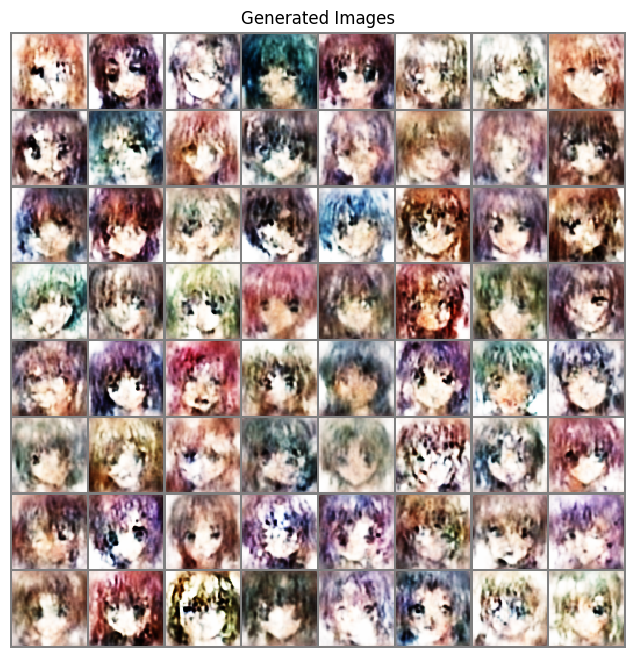

Epoch 10
[100/469]  loss: (l1=0.0532 ssim=0.1103 -> 0.3956) vae=0.1057 -> 0.5014
[200/469]  loss: (l1=0.0559 ssim=0.1174 -> 0.4202) vae=0.0930 -> 0.5133
[300/469]  loss: (l1=0.0545 ssim=0.1083 -> 0.3903) vae=0.1079 -> 0.4983
[400/469]  loss: (l1=0.0550 ssim=0.1078 -> 0.3889) vae=0.1082 -> 0.4971
Epoch 11
[100/469]  loss: (l1=0.0556 ssim=0.1125 -> 0.4046) vae=0.0971 -> 0.5017
[200/469]  loss: (l1=0.0600 ssim=0.1144 -> 0.4142) vae=0.1018 -> 0.5159
[300/469]  loss: (l1=0.0560 ssim=0.1114 -> 0.4013) vae=0.1043 -> 0.5056
[400/469]  loss: (l1=0.0570 ssim=0.1156 -> 0.4154) vae=0.1115 -> 0.5269
Epoch 12
[100/469]  loss: (l1=0.0549 ssim=0.1087 -> 0.3916) vae=0.1133 -> 0.5050
[200/469]  loss: (l1=0.0549 ssim=0.1054 -> 0.3812) vae=0.1089 -> 0.4900
[300/469]  loss: (l1=0.0543 ssim=0.0994 -> 0.3615) vae=0.1012 -> 0.4626
[400/469]  loss: (l1=0.0549 ssim=0.1078 -> 0.3888) vae=0.1003 -> 0.4890
Epoch 13
[100/469]  loss: (l1=0.0545 ssim=0.1070 -> 0.3861) vae=0.1084 -> 0.4946
[200/469]  loss: (l1=0.0540 

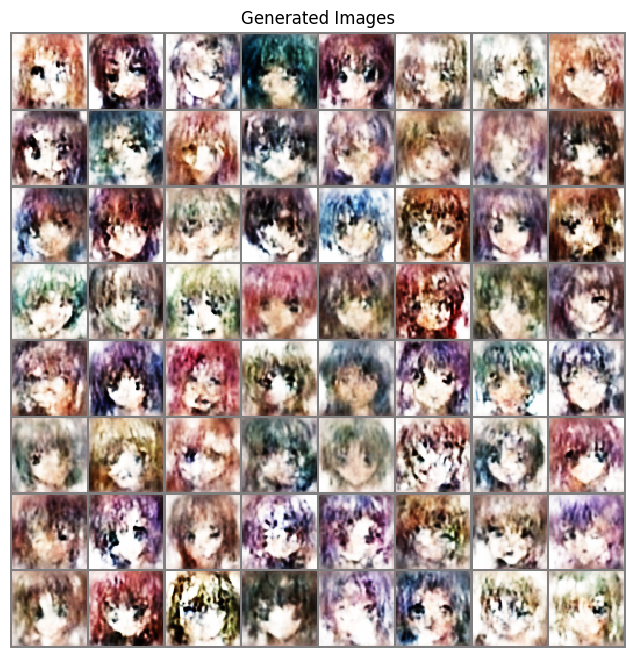

Epoch 17
[100/469]  loss: (l1=0.0520 ssim=0.0921 -> 0.3364) vae=0.0970 -> 0.4334
[200/469]  loss: (l1=0.0535 ssim=0.0959 -> 0.3496) vae=0.1063 -> 0.4559
[300/469]  loss: (l1=0.0527 ssim=0.0927 -> 0.3387) vae=0.1032 -> 0.4419
[400/469]  loss: (l1=0.0546 ssim=0.0976 -> 0.3560) vae=0.0980 -> 0.4541
Epoch 18
[100/469]  loss: (l1=0.0557 ssim=0.1006 -> 0.3664) vae=0.1063 -> 0.4727
[200/469]  loss: (l1=0.0548 ssim=0.0974 -> 0.3556) vae=0.1026 -> 0.4581
[300/469]  loss: (l1=0.0545 ssim=0.0966 -> 0.3528) vae=0.0982 -> 0.4509
[400/469]  loss: (l1=0.0546 ssim=0.0970 -> 0.3541) vae=0.1024 -> 0.4565
Epoch 19
[100/469]  loss: (l1=0.0531 ssim=0.0959 -> 0.3494) vae=0.1119 -> 0.4613
[200/469]  loss: (l1=0.0539 ssim=0.0929 -> 0.3404) vae=0.1076 -> 0.4480
[300/469]  loss: (l1=0.0546 ssim=0.0922 -> 0.3388) vae=0.0995 -> 0.4384
[400/469]  loss: (l1=0.0554 ssim=0.0950 -> 0.3485) vae=0.0958 -> 0.4443
Epoch 20
[100/469]  loss: (l1=0.0543 ssim=0.0970 -> 0.3538) vae=0.1144 -> 0.4682
[200/469]  loss: (l1=0.0510 

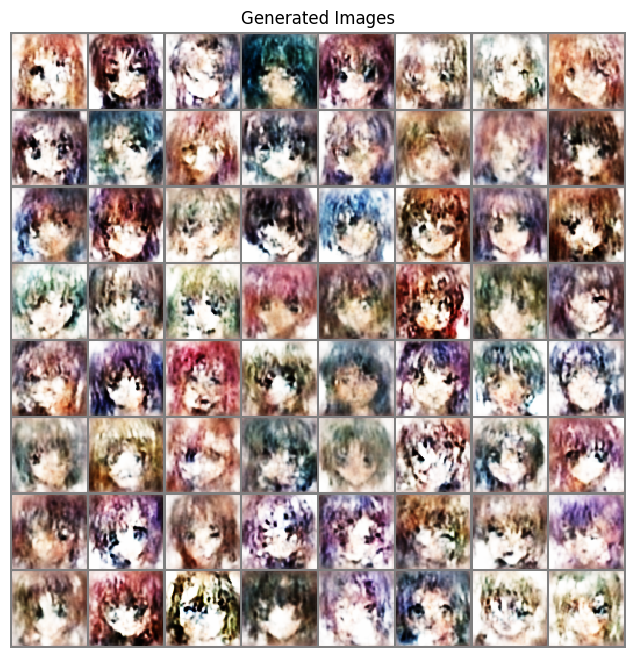

Epoch 26
[100/469]  loss: (l1=0.0532 ssim=0.0903 -> 0.3314) vae=0.1108 -> 0.4422
[200/469]  loss: (l1=0.0535 ssim=0.0854 -> 0.3162) vae=0.1055 -> 0.4217
[300/469]  loss: (l1=0.0557 ssim=0.0917 -> 0.3380) vae=0.1013 -> 0.4393
[400/469]  loss: (l1=0.0556 ssim=0.0908 -> 0.3351) vae=0.0999 -> 0.4350
Epoch 27
[100/469]  loss: (l1=0.0536 ssim=0.0898 -> 0.3304) vae=0.1093 -> 0.4397
[200/469]  loss: (l1=0.0522 ssim=0.0861 -> 0.3171) vae=0.1041 -> 0.4212
[300/469]  loss: (l1=0.0527 ssim=0.0867 -> 0.3195) vae=0.0921 -> 0.4116
[400/469]  loss: (l1=0.0540 ssim=0.0858 -> 0.3177) vae=0.1128 -> 0.4304
Epoch 28
[100/469]  loss: (l1=0.0539 ssim=0.0879 -> 0.3245) vae=0.1102 -> 0.4347
[200/469]  loss: (l1=0.0541 ssim=0.0889 -> 0.3279) vae=0.1015 -> 0.4294
[300/469]  loss: (l1=0.0540 ssim=0.0851 -> 0.3156) vae=0.1162 -> 0.4318
[400/469]  loss: (l1=0.0531 ssim=0.0895 -> 0.3289) vae=0.1046 -> 0.4336
Epoch 29
[100/469]  loss: (l1=0.0522 ssim=0.0848 -> 0.3132) vae=0.0984 -> 0.4116
[200/469]  loss: (l1=0.0528 

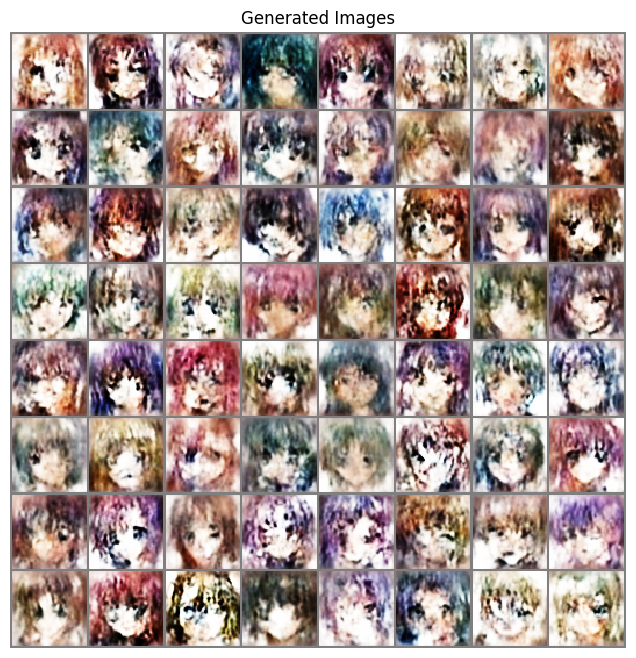

Epoch 37
[100/469]  loss: (l1=0.0523 ssim=0.0805 -> 0.2996) vae=0.1135 -> 0.4131
[200/469]  loss: (l1=0.0512 ssim=0.0813 -> 0.3011) vae=0.1137 -> 0.4148
[300/469]  loss: (l1=0.0530 ssim=0.0846 -> 0.3133) vae=0.0946 -> 0.4079
[400/469]  loss: (l1=0.0499 ssim=0.0783 -> 0.2903) vae=0.0951 -> 0.3854
Epoch 38
[100/469]  loss: (l1=0.0502 ssim=0.0804 -> 0.2974) vae=0.1144 -> 0.4118
[200/469]  loss: (l1=0.0511 ssim=0.0800 -> 0.2970) vae=0.0967 -> 0.3938
[300/469]  loss: (l1=0.0483 ssim=0.0760 -> 0.2819) vae=0.0994 -> 0.3813
[400/469]  loss: (l1=0.0517 ssim=0.0822 -> 0.3042) vae=0.1008 -> 0.4051
Epoch 39
[100/469]  loss: (l1=0.0500 ssim=0.0761 -> 0.2837) vae=0.1216 -> 0.4052
[200/469]  loss: (l1=0.0540 ssim=0.0830 -> 0.3088) vae=0.1033 -> 0.4121
[300/469]  loss: (l1=0.0518 ssim=0.0799 -> 0.2972) vae=0.0934 -> 0.3906
[400/469]  loss: (l1=0.0509 ssim=0.0812 -> 0.3004) vae=0.1237 -> 0.4242
Epoch 40
[100/469]  loss: (l1=0.0572 ssim=0.0849 -> 0.3173) vae=0.1007 -> 0.4180
[200/469]  loss: (l1=0.0515 

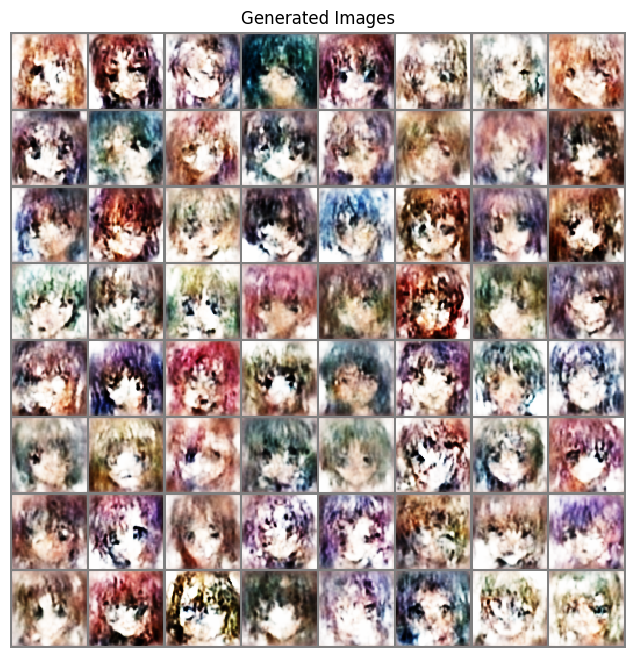

Epoch 50
[100/469]  loss: (l1=0.0528 ssim=0.0810 -> 0.3013) vae=0.1043 -> 0.4056
[200/469]  loss: (l1=0.0500 ssim=0.0782 -> 0.2901) vae=0.0969 -> 0.3870
[300/469]  loss: (l1=0.0497 ssim=0.0745 -> 0.2784) vae=0.1009 -> 0.3793
[400/469]  loss: (l1=0.0516 ssim=0.0756 -> 0.2831) vae=0.0998 -> 0.3829
Epoch 51
[100/469]  loss: (l1=0.0502 ssim=0.0772 -> 0.2871) vae=0.1144 -> 0.4015
[200/469]  loss: (l1=0.0475 ssim=0.0713 -> 0.2660) vae=0.1112 -> 0.3772
[300/469]  loss: (l1=0.0493 ssim=0.0740 -> 0.2764) vae=0.1056 -> 0.3820
[400/469]  loss: (l1=0.0578 ssim=0.0832 -> 0.3124) vae=0.1044 -> 0.4168
Epoch 52
[100/469]  loss: (l1=0.0520 ssim=0.0788 -> 0.2939) vae=0.0995 -> 0.3934
[200/469]  loss: (l1=0.0519 ssim=0.0801 -> 0.2979) vae=0.1142 -> 0.4122
[300/469]  loss: (l1=0.0522 ssim=0.0803 -> 0.2986) vae=0.1211 -> 0.4197
[400/469]  loss: (l1=0.0545 ssim=0.0826 -> 0.3081) vae=0.1114 -> 0.4195
Epoch 53
[100/469]  loss: (l1=0.0522 ssim=0.0771 -> 0.2886) vae=0.1101 -> 0.3987
[200/469]  loss: (l1=0.0492 

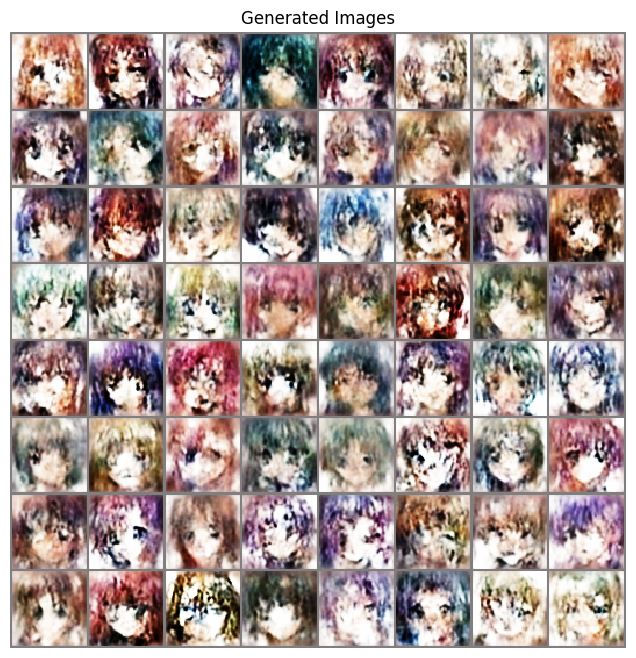

Epoch 65
[100/469]  loss: (l1=0.0549 ssim=0.0798 -> 0.2994) vae=0.0999 -> 0.3993
[200/469]  loss: (l1=0.0539 ssim=0.0797 -> 0.2982) vae=0.1025 -> 0.4006
[300/469]  loss: (l1=0.0485 ssim=0.0723 -> 0.2700) vae=0.1126 -> 0.3826
[400/469]  loss: (l1=0.0503 ssim=0.0730 -> 0.2740) vae=0.0951 -> 0.3691
Epoch 66
[100/469]  loss: (l1=0.0508 ssim=0.0747 -> 0.2796) vae=0.1137 -> 0.3933
[200/469]  loss: (l1=0.0512 ssim=0.0733 -> 0.2755) vae=0.1010 -> 0.3765
[300/469]  loss: (l1=0.0551 ssim=0.0770 -> 0.2904) vae=0.1104 -> 0.4008
[400/469]  loss: (l1=0.0517 ssim=0.0751 -> 0.2817) vae=0.1059 -> 0.3876
Epoch 67
[100/469]  loss: (l1=0.0487 ssim=0.0719 -> 0.2689) vae=0.1056 -> 0.3745
[200/469]  loss: (l1=0.0504 ssim=0.0727 -> 0.2729) vae=0.1158 -> 0.3887
[300/469]  loss: (l1=0.0496 ssim=0.0742 -> 0.2771) vae=0.1020 -> 0.3791
[400/469]  loss: (l1=0.0494 ssim=0.0699 -> 0.2633) vae=0.1139 -> 0.3772
Epoch 68
[100/469]  loss: (l1=0.0476 ssim=0.0680 -> 0.2557) vae=0.0991 -> 0.3548
[200/469]  loss: (l1=0.0489 

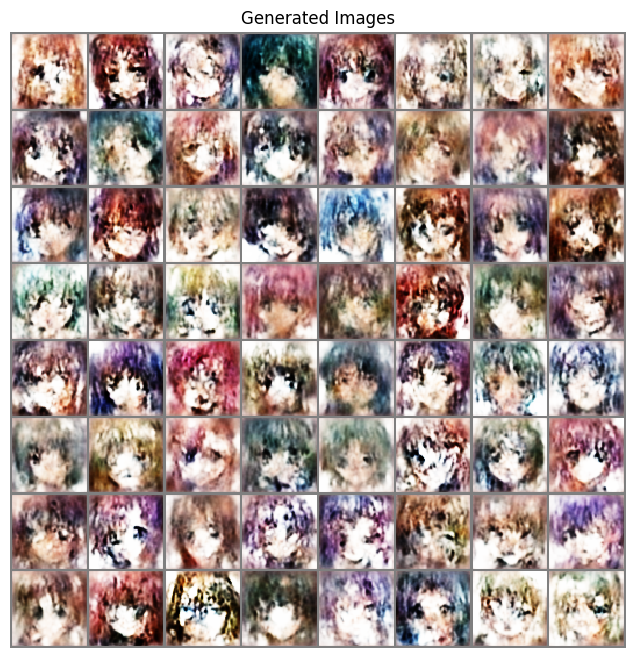

Epoch 82
[100/469]  loss: (l1=0.0527 ssim=0.0741 -> 0.2792) vae=0.0976 -> 0.3768
[200/469]  loss: (l1=0.0508 ssim=0.0740 -> 0.2774) vae=0.0958 -> 0.3733
[300/469]  loss: (l1=0.0474 ssim=0.0673 -> 0.2532) vae=0.1103 -> 0.3635
[400/469]  loss: (l1=0.0520 ssim=0.0734 -> 0.2764) vae=0.1019 -> 0.3783
Epoch 83
[100/469]  loss: (l1=0.0507 ssim=0.0735 -> 0.2757) vae=0.1030 -> 0.3787
[200/469]  loss: (l1=0.0479 ssim=0.0699 -> 0.2620) vae=0.1008 -> 0.3629
[300/469]  loss: (l1=0.0524 ssim=0.0718 -> 0.2716) vae=0.0978 -> 0.3694
[400/469]  loss: (l1=0.0492 ssim=0.0727 -> 0.2719) vae=0.0947 -> 0.3666
Epoch 84
[100/469]  loss: (l1=0.0502 ssim=0.0743 -> 0.2779) vae=0.1028 -> 0.3807
[200/469]  loss: (l1=0.0500 ssim=0.0707 -> 0.2663) vae=0.1148 -> 0.3812
[300/469]  loss: (l1=0.0482 ssim=0.0696 -> 0.2612) vae=0.1010 -> 0.3623
[400/469]  loss: (l1=0.0496 ssim=0.0752 -> 0.2803) vae=0.1072 -> 0.3875
Epoch 85
[100/469]  loss: (l1=0.0484 ssim=0.0693 -> 0.2606) vae=0.1048 -> 0.3655
[200/469]  loss: (l1=0.0499 

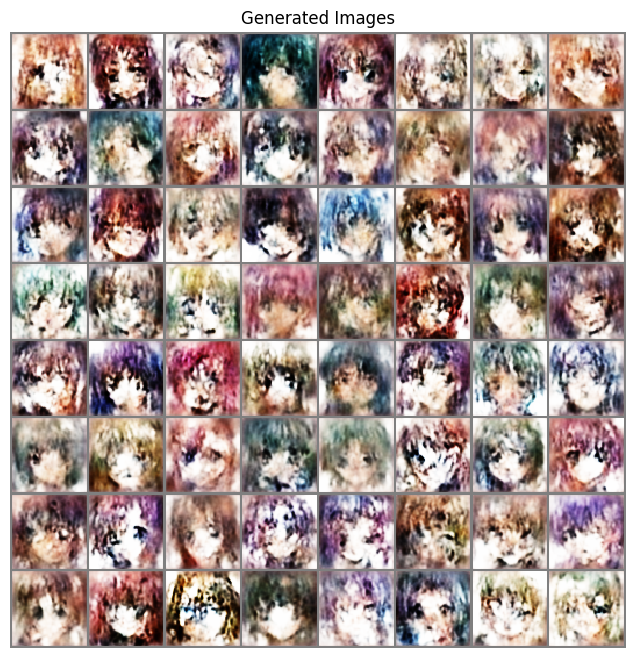

In [4]:
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM


def weights_init(m):
    classname = m.__class__.__name__
    if 'BatchNorm' in classname:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.normal_(m.bias.data, 0.0, 0.02)
    elif 'Linear' in classname:
        if 'weight' in m.__dict__ and m.weight is not None:
            nn.init.normal_(m.weight.data, 0.0, 0.1)
        if 'bias' in m.__dict__ and m.bias is not None:
            nn.init.normal_(m.bias.data, 0.0, 0.1)
    else:
        if 'weight' in m.__dict__ and m.weight is not None:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        if 'bias' in m.__dict__ and m.bias is not None:
            nn.init.normal_(m.bias.data, 0.0, 0.02)


def train_epoch(epoch, dataloader, net_e, net_g, loss_fn, optimizer_e, optimizer_g):

    net_e_params = torch.cat([x.view(-1) for x in net_e.parameters()])
    net_g_params = torch.cat([x.view(-1) for x in net_g.parameters()])

    for batch, x in enumerate(dataloader, 0):
        real = x.to(device)*2.0-1.0

        encoded = net_e(real)
        fake = net_g(encoded)

        # loss between real and fake
        loss_l1 = 0.5*torch.mean(torch.abs(fake-real))
        loss_ssim = 1 - ssim(0.5+0.5*real, 0.5+0.5*fake, data_range=1, size_average=True)
        ssim_t = 0.8 * np.clip((epoch-1)/(10-1), 0, 1)
        loss_diff = 4.0*((1-ssim_t)*loss_l1+ssim_t*loss_ssim)

        # KL divergence loss for VAE
        encoded_mean = torch.mean(encoded, axis=0)
        encoded_cov = torch.cov(encoded.T)
        p1 = torch.distributions.multivariate_normal.MultivariateNormal(
            encoded_mean, encoded_cov)
        p2 = torch.distributions.multivariate_normal.MultivariateNormal(
            torch.zeros_like(encoded_mean, device=device),
            torch.eye(LATENT, device=device))
        loss_vae = 0.01 * torch.distributions.kl_divergence(p1, p2)

        # train encoder/generator
        net_e.zero_grad()
        net_g.zero_grad()
        loss = loss_diff + loss_vae
        loss.backward()
        optimizer_e.step()
        optimizer_g.step()

        # output stats
        if (batch+1) % 100 == 0:
            print('[%d/%d]  loss: (l1=%.4f ssim=%.4f -> %.4f) vae=%.4f -> %.4f'
                  % (batch+1, len(dataloader),
                     loss_l1.item(),
                     loss_ssim.item(),
                     loss_diff.item(),
                     loss_vae.item(),
                     loss.item()))
            # break


def count_weights(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


# load data
dataloader = load_data(AnimeFaceDataset())

# creat models
net_e = Encoder().to(device)
print("Encoder", count_weights(net_e))
print(net_e)

net_g = Generator().to(device)
print("Decoder", count_weights(net_g))
print(net_g)

try:
    net_e.load_state_dict(torch.load(MODEL_E_PATH, map_location=device))
    net_g.load_state_dict(torch.load(MODEL_G_PATH, map_location=device))
    print("Model loaded from file.")
except BaseException as e:
    net_e.apply(weights_init)
    net_g.apply(weights_init)
    print("Model weights initialized.")

# loss function and optimizer
loss_fn = nn.BCELoss()
optimizer_e = torch.optim.Adam(net_e.parameters(),
                                lr=0.001, betas=(0.9, 0.999))
optimizer_g = torch.optim.Adam(net_g.parameters(),
                                lr=0.001, betas=(0.9, 0.999))

# train with progress
fixed_noise = torch.randn(64, LATENT, device=device)
for epoch in range(1, 100+1):
    # train
    print("Epoch", epoch)
    train_epoch(epoch, dataloader, net_e, net_g, loss_fn, optimizer_e, optimizer_g)
    # plot
    epoch_sqrt = int(epoch**0.5+1e-6)
    if epoch == epoch_sqrt**2:
        generated = net_g(fixed_noise)*0.5+0.5
        plt.figure(figsize=(8, 8))
        plt.axis("off")
        plt.title("Generated Images")
        plt.imshow(np.transpose(vutils.make_grid(
            generated,
            padding=2, pad_value=0.5, normalize=True).cpu(), (1, 2, 0)),
                    interpolation='nearest')
        plt.show() # on 

# export weights

torch.save(net_e.state_dict(), MODEL_E_PATH)
torch.save(net_g.state_dict(), MODEL_G_PATH)


Shape of x: torch.Size([128, 3, 64, 64])
Model loaded from file.


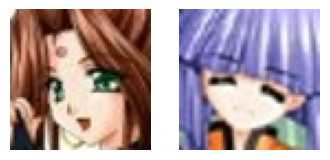

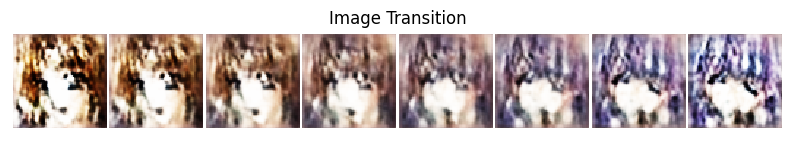

In [5]:
# load data
dataloader = load_data(AnimeFaceDataset())

# creat models
net_e = Encoder().to(device)
net_g = Generator().to(device)

net_e.load_state_dict(torch.load(MODEL_E_PATH, map_location=device))
net_g.load_state_dict(torch.load(MODEL_G_PATH, map_location=device))
print("Model loaded from file.")

for batch in dataloader:
    img1 = batch[0:1]
    img2 = batch[1:2]
    # break

from PIL import Image
# img1 = torch.tensor([np.array(Image.open("/home/harry7557558/me.png").convert("RGB").resize((64,64)), dtype=np.float32)/255.0]).permute(0, 3, 1, 2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(4, 10))
ax1.imshow(img1[0].permute(1, 2, 0))
ax2.imshow(img2[0].permute(1, 2, 0))
ax1.axis("off")
ax2.axis("off")
plt.show()

n = 8
enc1 = net_e(img1.to(device))
enc2 = net_e(img2.to(device))
t = torch.linspace(0, 1, n, device=device)
enc = enc1 + (enc2-enc1) * t[:, None]
img = net_g(enc)*0.5+0.5

plt.figure(figsize=(10, 30))
plt.axis("off")
plt.title("Image Transition")
plt.imshow(np.transpose(vutils.make_grid(
    img,
    padding=2, pad_value=1, normalize=True).cpu(), (1, 2, 0)),
            interpolation='nearest')
plt.show() # on ipynb


In [6]:
param_i = 0
layers = {}
prev_class = None
prev_path = None
for layer in net_g.main:
    if layer.__class__.__name__ == "Linear":
        param_i += 1
        data = list(layer.parameters())[0].data.cpu()
        shape = '_'.join(map(str, data.shape))
        path = EXPORT_PATH+"/w{:02d}_{}.bin".format(param_i, shape)
        layers[path] = data.numpy()
        prev_path = path
        if len(list(layer.parameters())) > 1:
            data = list(layer.parameters())[1].data.cpu()
            shape = '_'.join(map(str, data.shape))
            path = EXPORT_PATH+"/b{:02d}_{}.bin".format(param_i, shape)
            layers[path] = data.numpy()
            prev_path = (prev_path, path)
    elif layer.__class__.__name__ in ['Conv2d', "ConvTranspose2d"]:
        param_i += 1
        data = list(layer.parameters())[0].data.cpu()  # no bias
        shape = '_'.join(map(str, data.shape))
        path = EXPORT_PATH+"/w{:02d}_{}.bin".format(param_i, shape)
        layers[path] = data.numpy()
        prev_path = path
    elif layer.__class__.__name__ == "BatchNorm2d":
        assert len(layers[prev_path].shape) == 4
        mu = layer.running_mean.cpu()
        var = layer.running_var.cpu()
        invstdev = 1.0 / (var + 1e-5)**0.5
        data = list(layer.parameters())
        gamma, beta = data[0].data.cpu(), data[1].data.cpu()
        a = gamma * invstdev
        b = beta - mu * gamma * invstdev
        a, b = a.numpy(), b.numpy()
        # print(prev_class, layers[prev_path].shape, a.shape)
        if prev_class == 'ConvTranspose2d':
            layers[prev_path] = layers[prev_path] * a[:, np.newaxis, np.newaxis]
        elif prev_class == 'Conv2d':
            layers[prev_path] = layers[prev_path] * a[:, np.newaxis, np.newaxis, np.newaxis]
        # print(a.shape, b.shape, layers[prev_path].shape)
        shape = '_'.join(map(str, b.shape))
        path = EXPORT_PATH+"/b{:02d}_{}.bin".format(param_i, shape)
        layers[path] = b
    else:
        print(layer.__class__.__name__)
        prev_path = None
    prev_class = layer.__class__.__name__

for path, data in layers.items():
    data.astype(np.float32).tofile(path)

SiLU
Unflatten
SiLU
SiLU
SiLU
SiLU
Tanh
